In [1]:
from src.scut import *
from src.Zha_clust import *

import numpy as np

import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score, classification_report

In [2]:
from sklearn import datasets

iris = datasets.load_iris()

In [3]:
data = iris.data

#min max scaling
iris_data =  iris.data-iris.data.min(0)
iris_data = iris_data/iris_data.max(0)


iris_data = np.concatenate((iris_data,1-iris_data),1)


In [4]:
seq_ids = []

cpt_dict = {0:0,1:0,2:0}

for tgt in iris.target:
    cpt = cpt_dict[tgt]
    seq_id = str(tgt)+"_"+str(cpt)
    cpt_dict[tgt] += 1
    seq_ids.append(seq_id)

In [7]:
tree_Scut = ClusterDataToTree(iris_data,seq_ids, fname = "trees/iris.tree", th_mode="kde",mode="valley",K=10,n_min=1)
tree_Zha = ClusterDataToTreeZha(iris_data,seq_ids, fname = "trees/iris_Zha.tree")

In [26]:
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score, classification_report

def leaf_name_to_high_lab(leaf_name):
    idx = int(leaf_name.split("_")[0])
    return high_lab, idx

def KL(a, b):
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

def get_dist_memo(memo,tree):
    if tree.name not in memo:
        lab_count = np.zeros(7)
        for i in tree.get_leaf_names():
            _, idx = leaf_name_to_high_lab(i)
            lab_count[idx] += 1
        memo[tree.name] = lab_count/lab_count.sum()
    return memo[tree.name]

memo = dict()
def split(tree,th,memo):
    res = []
    unc = []
    todo = [tree]
    
    while todo:
        curr = todo.pop()
        dist_parent = get_dist_memo(memo,curr)
        if len(curr.children) == 2:
            left,right = curr.children
            dist_left, dist_right = get_dist_memo(memo,left),get_dist_memo(memo,right)
            with warnings.catch_warnings(action="ignore"):
                if (KL(dist_left,dist_parent) > th) or (KL(dist_right,dist_parent) > th):
                    todo.append(left)
                    todo.append(right)
                else:
                    res.append(curr)
        else:
            unc.append(curr)
    return res,unc

def get_dist_memo(memo,tree):
    if tree.name not in memo:
        lab_count = np.zeros(7)
        for i in tree.get_leaf_names():
            _, idx = leaf_name_to_high_lab(i)
            lab_count[idx] += 1
        memo[tree.name] = lab_count
    return memo[tree.name]


th = 5
def get_pred(leaf,true,memo,th=th):
    ancestors = leaf.get_ancestors()
    for ances in ancestors:
        if len(ances) < th:
            continue
        break
    dist = get_dist_memo(memo,ances).copy()
    dist[true]-=1
    pred = dist.argmax()
    return pred

mcc=0.8802347605750713
accuracy: 0.92
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.90      0.86      0.88        50
   virginica       0.87      0.90      0.88        50

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150



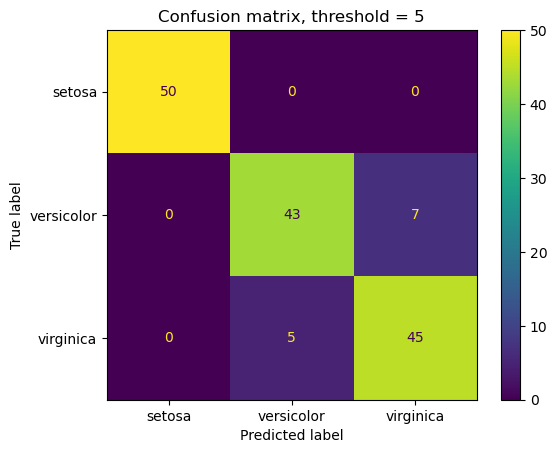

In [27]:
l_pos_na = ["setosa","versicolor","virginica"]
high_lab = l_pos_na

t = Tree("trees/iris.tree",format=1)
memo1 = dict()
th = 5
l_high_lab = l_pos_na
conf_mat = np.zeros((3,3))
y_true = []
y_pred = []
for leaf in t:
    high_lab, true = leaf_name_to_high_lab(leaf.name)
    pred = get_pred(leaf,true,memo1,th=th)
    conf_mat[true,pred] += 1
    y_true.append(true)
    y_pred.append(pred)
    

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, threshold = "+str(th))
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))

In [28]:
l_col = ["#1f77b4","#ff7f0e","#2ca02c"]

memo1 = dict()
l_high = l_high_lab
l_col_high = l_col
with open('iTOL/Iris/itol_Iris_strip_Bottom-Up_pred_SCUT.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_pred_bottom-up\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_pred_bottom-up\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    
    f.write("DATA\n")
    

    for leaf in t:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        pred = get_pred(leaf,true,memo1,th=th)
        seq_id = leaf.name
        col = l_col_high[pred]
        label = l_high[pred]
        f.write(seq_id+"\t"+col+"\t"+label+"\n")

mcc=0.7241882392784904
accuracy: 0.8066666666666666
              precision    recall  f1-score   support

      setosa       1.00      0.90      0.95        50
  versicolor       0.65      0.90      0.76        50
   virginica       0.86      0.62      0.72        50

    accuracy                           0.81       150
   macro avg       0.84      0.81      0.81       150
weighted avg       0.84      0.81      0.81       150



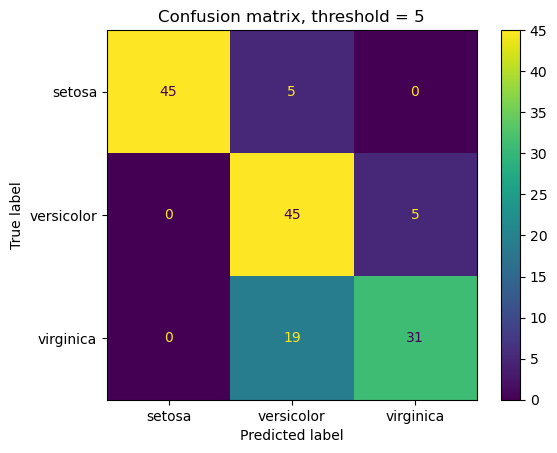

In [17]:
t = Tree("trees/iris_Zha.tree",format=1)
memo1 = dict()
th = 5
l_high_lab = l_pos_na
conf_mat = np.zeros((3,3))
y_true = []
y_pred = []
for leaf in t:
    high_lab, true = leaf_name_to_high_lab(leaf.name)
    pred = get_pred(leaf,true,memo1,th=th)
    conf_mat[true,pred] += 1
    y_true.append(true)
    y_pred.append(pred)
    

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, threshold = "+str(th))
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))

In [18]:
memo1 = dict()
l_high = l_high_lab
l_col_high = l_col
with open('iTOL/Iris/itol_Iris_strip_Bottom-Up_pred_Zha.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_pred_bottom-up\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_pred_bottom-up\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    
    f.write("DATA\n")
    

    for leaf in t:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        pred = get_pred(leaf,true,memo1,th=th)
        seq_id = leaf.name
        col = l_col_high[pred]
        label = l_high[pred]
        f.write(seq_id+"\t"+col+"\t"+label+"\n")

In [33]:
def get_dist_memo(memo,tree):
    if tree.name not in memo:
        lab_count = np.zeros(7)
        for i in tree.get_leaf_names():
            _, idx = leaf_name_to_high_lab(i)
            lab_count[idx] += 1
        memo[tree.name] = lab_count/lab_count.sum()
    return memo[tree.name]

def split(tree,th,memo):
    res = []
    unc = []
    todo = [tree]
    
    while todo:
        curr = todo.pop()
        dist_parent = get_dist_memo(memo,curr)
        if len(curr.children) == 2:
            left,right = curr.children
            dist_left, dist_right = get_dist_memo(memo,left),get_dist_memo(memo,right)
            with warnings.catch_warnings(action="ignore"):
                if (KL(dist_left,dist_parent) > th) or (KL(dist_right,dist_parent) > th):
                    todo.append(left)
                    todo.append(right)
                else:
                    res.append(curr)
        elif len(curr.children) == 0:
            unc.append(curr)
        else:
            res.append(curr)
    return res,unc
    

In [34]:
t = Tree("trees/iris.tree",format=1)
memo1 = dict()

In [35]:
res, unc = split(t,0.15,memo1)
print(len([(i.name,len(i)) for i in res if len(i)>=5]))
print([(i.name,len(i)) for i in res if len(i)>5])
print(len([i.name for i in unc])+sum([len(i) for i in res if len(i)<5]))

5
[('I122', 27), ('I97', 26), ('I78', 20), ('I61', 16), ('I0', 50)]
11


mcc=0.957069540275903
acc_w_na=0.9
accuracy: 0.9712230215827338
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.93      0.98      0.96        44
   virginica       0.98      0.93      0.95        45

    accuracy                           0.97       139
   macro avg       0.97      0.97      0.97       139
weighted avg       0.97      0.97      0.97       139



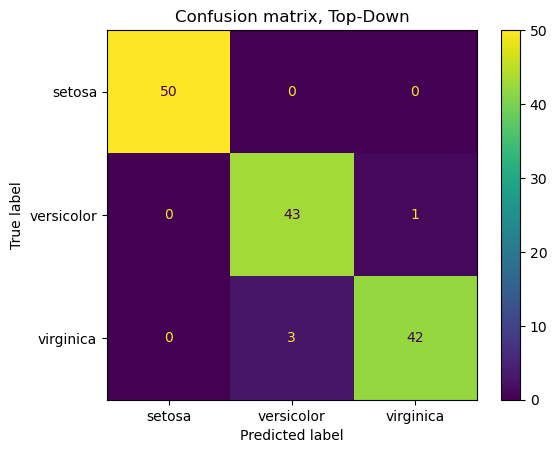

In [36]:
conf_mat = np.zeros((3,3))
y_true = []
y_pred = []

for st in [i for i in res if len(i)>=5]:
    pred = get_dist_memo(memo,st).argmax()
    for leaf in st:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        conf_mat[true,pred] += 1
        y_true.append(true)
        y_pred.append(pred)
    

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, Top-Down")
acc = conf_mat.diagonal().sum()/conf_mat.sum()
acc_w_na = conf_mat.diagonal().sum()/len(t)
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f"{acc_w_na=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))

In [37]:
with open('iTOL/Iris/itol_Iris_strip_Top-Down_pred_SCUT.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_pred_bottom-up\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_pred_bottom-up\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col_high)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    
    f.write("DATA\n")
    

    for st in [i for i in res if len(i)>=5]: #set of selected subtrees with more than 15 leaves
        pred = get_dist_memo(memo1,st).argmax()
        label = l_high[pred]
        col = l_col_high[pred]
        for i in st:
            seq_id = i.name
            f.write(seq_id+"\t"+col+"\t"+label+"\n")

In [38]:
t = Tree("trees/iris_Zha.tree",format=1)
memo1 = dict()

In [39]:
res, unc = split(t,0.02,memo1)
print(len([(i.name,len(i)) for i in res if len(i)>=5]))
print([(i.name,len(i)) for i in res if len(i)>5])
print(len([i.name for i in unc])+sum([len(i) for i in res if len(i)<5]))

7
[('I13', 47), ('I12', 24), ('I11', 7), ('I10', 12), ('I6', 31), ('I5', 15), ('I2', 14)]
0


mcc=0.7241882392784904
acc_w_na=0.8066666666666666
accuracy: 0.8066666666666666
              precision    recall  f1-score   support

      setosa       1.00      0.90      0.95        50
  versicolor       0.65      0.90      0.76        50
   virginica       0.86      0.62      0.72        50

    accuracy                           0.81       150
   macro avg       0.84      0.81      0.81       150
weighted avg       0.84      0.81      0.81       150



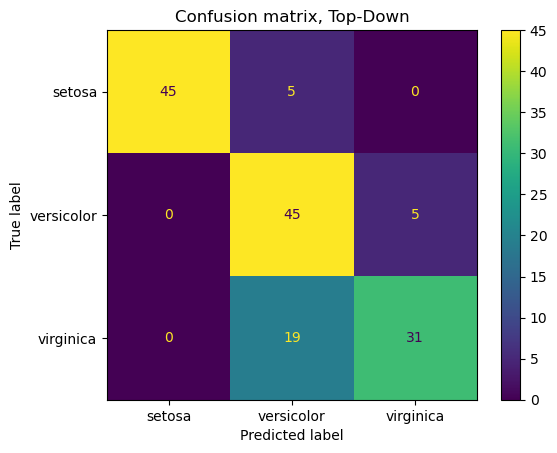

In [40]:
res, unc = split(t,0.02,memo1)
conf_mat = np.zeros((3,3))
y_true = []
y_pred = []

for st in [i for i in res if len(i)>=5]:
    pred = get_dist_memo(memo,st).argmax()
    for leaf in st:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        conf_mat[true,pred] += 1
        y_true.append(true)
        y_pred.append(pred)
    

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, Top-Down")
acc = conf_mat.diagonal().sum()/conf_mat.sum()
acc_w_na = conf_mat.diagonal().sum()/len(t)
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f"{acc_w_na=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))

In [41]:
with open('iTOL/Iris/itol_Iris_strip_Top-Down_pred_Zha.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_pred_bottom-up\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_pred_bottom-up\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col_high)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    
    f.write("DATA\n")
    

    for st in [i for i in res if len(i)>=5]: #set of selected subtrees with more than 15 leaves
        pred = get_dist_memo(memo1,st).argmax()
        label = l_high[pred]
        col = l_col_high[pred]
        for i in st:
            seq_id = i.name
            f.write(seq_id+"\t"+col+"\t"+label+"\n")